# Clusters annotation

The aim of this work is to identify the clusters by comparing the sequences to K12 genes. We blast K12 genes on a database constituted of one seqeunce per cluster. We align the different hits with K12 gene sequence and we record sequence similarity. As we are also looking for gene fragments we make a distinction between the global similarity (proportion of matches between both sequences once aligned) and the cluster similarity (proportion of matches on the proportion of the alignment that starts with the first base of the cluster sequence and that ends with its last base i.e. we remove the gaps at the beginning and the end of the alignment of the cluster sequence).

## Libraries imports

In [5]:
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Blast import NCBIXML       
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO

## Data

In [9]:
DATA_FOLDER = "../Data/Sequences/Clusters reference sequences/"
OUTPUT_FOLDER = "../Data/Clusters annotations/"

CLUSTERS_GAPS_FILE = DATA_FOLDER+"refseq.fasta" # Clusters reference sequences (fasta file)
CLUSTERS_FILE= DATA_FOLDER+"clusters.faa" #  Clusters reference sequences without gaps (fasta file)
SINGLETONS_FILE = DATA_FOLDER+"singletons.fasta" # Singletons sequences (fasta file)

K12_FILE = DATA_FOLDER+"K12.faa" # K12 sequences (fasta file)
BLAST_K12_CLUSTERS = DATA_FOLDER+"K12_clusters.xml" # BLAST output (K12 blasted against clusters database)
BLAST_K12_SINGLETONS = DATA_FOLDER+"K12_singletons.xml" # BLAST output (K12 blasted against singletons database)

ANNOTATIONS_CLUSTERS_CSV = OUTPUT_FOLDER+"annotations.csv" # Clusters annotations (csv file)
ANNOTATIONS_SINGLETONS_CSV = OUTPUT_FOLDER+"annotations_singletons.csv" # Singletons annotations (csv file)
ANNOTATIONS_GENES_CSV = OUTPUT_FOLDER+"annotations_genes.csv" # Clusters+Singletons annotations (csv file) 
UNIQUE_HPI_HITS_CSV = OUTPUT_FOLDER+"gene_unique_clusters.csv" # Clusters+Singletons annotations (csv file)
RESULTS_CLUSTERS = OUTPUT_FOLDER+"results_clusters" # pickle file to save clusters hits results (to load run `results = pickle.load(open(RESULTS_CLUSTERS, 'rb'))`)
RESULTS_SINGLETONS = OUTPUT_FOLDER+"results_singletons" # pickle file to save singletons hits results (to load run `results = pickle.load(open(RESULTS_SINGLETONS, 'rb'))`)

## Parameters

In [10]:
# BLAST e-value threshold
E_VALUE_THRESH = 0.00000001

# Similarity threshold between cluster sequence and gene sequence once aligned
SIMILARITY_THRESHOLD = 0.9

# Good alignment criteria: no more than max(MAX_GAPS_PROP*total number of characters,MAX_GAPS_ABS) gaps.
MAX_GAPS_ABS = 5
MAX_GAPS_PROP = 1/180 

## Reformatting fasta file

K12 genes (sequences + annotation) were downloaded from NCBI as a fasta file (`K12.faa`) and turned into a database for BLAST search by running `makeblastdb -in K12.faa -dbtype nucl`. Another fasta file gathering the one sequence of each cluster was created (`refseq.fasta`). The sequence was chosen to be the most representative of the cluster in terms of length. The code below allows to remove the gaps, the final file is called `clusters.faa`.

In [14]:
record = SeqIO.to_dict(SeqIO.parse(CLUSTERS_GAPS_FILE, "fasta"))
for seqid in record.keys():
    record[seqid].seq = Seq((str(record[seqid].seq).upper()).replace('-',''))
SeqIO.write(list(record.values()),CLUSTERS_FILE,"fasta")

160177

`clusters.faa` was turned into a database for BLAST search by running `makeblastdb -in clusters.faa -dbtype nucl`. `singletons.fasta` was turned into a database for BLAST search by running `makeblastdb -in singletons.fasta -dbtype nucl`. BLAST searches were performed by running `blastn -out K12_clusters.xml -outfmt 5 -query K12.faa -db clusters -evalue 0.001` and `blastn -out K12_singletons.xml -outfmt 5 -query K12.faa -db singletons -evalue 0.001`.

## Sequences length

We record all the sequences in two dictionnaries, one for K12 and one for the clusters. It will allow to easily look for information about a sequence (annotation, length, etc).

In [11]:
SINGLETONS_FASTA = SeqIO.to_dict(SeqIO.parse(SINGLETONS_FILE, "fasta"))    
CLUSTERS_FASTA = SeqIO.to_dict(SeqIO.parse(CLUSTERS_FILE, "fasta"))
CLUSTERS_GAPS_FASTA = SeqIO.to_dict(SeqIO.parse(CLUSTERS_GAPS_FILE, "fasta"))
SEQUENCES_FASTA = dict(SINGLETONS_FASTA, **CLUSTERS_FASTA)
K12_FASTA = SeqIO.to_dict(SeqIO.parse(K12_FILE, "fasta"))

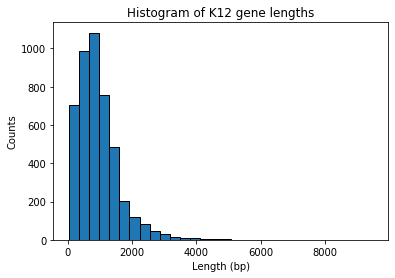

In [12]:
L = []
for key in K12_FASTA.keys():
    L += [len(Seq((str(K12_FASTA[key].seq))))]

plt.hist(L,bins=30,edgecolor='black')
plt.title("Histogram of K12 gene lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Counts")
#plt.xlim(0,5000)
plt.show()

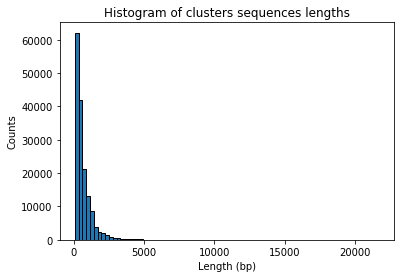

In [13]:
L = []
for key in CLUSTERS_FASTA.keys():
    L += [len(Seq((str(CLUSTERS_FASTA[key].seq))))]

plt.hist(L,bins=80,edgecolor='black')
plt.title("Histogram of clusters sequences lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Counts")
#plt.xlim(0,5000)
plt.show()

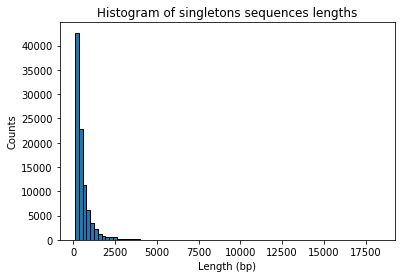

In [14]:
L = []
for key in SINGLETONS_FASTA.keys():
    L += [len(Seq((str(SINGLETONS_FASTA[key].seq))))]

plt.hist(L,bins=80,edgecolor='black')
plt.title("Histogram of singletons sequences lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Counts")
#plt.xlim(0,5000)
plt.show()

## Blast hit class

We define a python class to record hits characteristics easily.

In [15]:
class Hit:
    similarity_threshold = SIMILARITY_THRESHOLD
    gene_dict = K12_FASTA
    cluster_dict = SEQUENCES_FASTA
    
    def __init__(self, gene_name, cluster_name, global_similarity, cluster_similarity, start_gap, end_gap):
        self.gene_name = gene_name
        self.cluster_name = cluster_name
        self.global_similarity = global_similarity
        self.cluster_similarity = cluster_similarity
        self.start_gap = start_gap
        self.end_gap = end_gap
        
    def get_gene_name(self):
        description = self.gene_dict[self.gene_name].description
        if("[gene=" in description):
            return description.split("[gene=")[1].split("]")[0]
        else:
            return ""

    def get_gene_length(self):
        return len(Seq((str(self.gene_dict[self.gene_name].seq))))
    
    def get_cluster_length(self):
        return len(Seq((str(self.cluster_dict[self.cluster_name].seq))))

    def is_similar(self):
        return self.global_similarity > self.similarity_threshold
    
    def is_fragment(self):
        return self.get_cluster_length()<=0.9*self.get_gene_length() and self.cluster_similarity > self.similarity_threshold


## Parsing BLAST results

### Clusters annotations

For each BLAST hit of K12 against the Clusters database we align both sequences and we measure the similarity between both sequences and record it as a Hit object in a dictionnary indexed by K12 gene names. As the code is long to run we print the number of genes processed every 500 genes and we store the results as a pickle object.

In [108]:
result_handle = open(BLAST_K12_CLUSTERS)
blast_records = NCBIXML.parse(result_handle)

muscle_cline = MuscleCommandline(input="algnt_temp.fasta", out="algnt_temp.txt")
results = dict()

counter = 0
for blast_record in blast_records:
    query = blast_record.query
    algnt = dict()
    refname = query.split(' ')[0]
    results[refname] = []
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps: 
            if hsp.expect < E_VALUE_THRESH:
                algnt[alignment.title.split(' ')[1]] = CLUSTERS_FASTA[alignment.title.split(' ')[1]]
    if(len(algnt.keys())>0):
        L = list(algnt.values())
        for i in range(len(L)):
            SeqIO.write([K12_FASTA[refname]] + [L[i]],"algnt_temp.fasta","fasta") 
            muscle_cline()
            align = AlignIO.read("algnt_temp.txt", "fasta")
            refindex = 0
            hitindex = 1
            if(align[1,:].name==refname):
                refindex = 1
                hitindex = 0
            refseq = str(align[refindex,:].seq)
            hitseq = str(align[hitindex,:].seq)
            lref = len(refseq)
            global_sim = 0
            cluster_sim = 0
            start_gap = (hitseq[0]=="-")
            end_gap = (hitseq[-1]=="-")
            gaps = [hitseq[i]=="-" for i in range(len(hitseq))]
            start = gaps.index(False)
            end = len(hitseq)-gaps[::-1].index(False)
            for i in range(lref):
                if(refseq[i]==hitseq[i]):
                    global_sim += 1
                    if(i>=start and i<end):
                        cluster_sim += 1
            hit = Hit(refname, align[hitindex,:].name, global_sim/lref, cluster_sim/(end-start), start_gap, end_gap)
            results[refname].append(hit)
    if(counter%500==0):
        print(str(counter)+" genes processed")
    counter += 1
pickle.dump(results, open(RESULTS_CLUSTERS, 'wb'))     

0
500
1000
1500
2000
2500
3000
3500
4000
4500


We create a second dictionnary indexed by cluster names to store the results in a different order.

In [ ]:
reverse_results = dict()
for key in results.keys():
    hits = results[key]
    for i in range(len(hits)):
        if(not hits[i].cluster_name in reverse_results.keys()):
            reverse_results[hits[i].cluster_name] = []
        reverse_results[hits[i].cluster_name].append(hits[i])

We output the results as a csv file.

In [ ]:
file = open(ANNOTATIONS_CLUSTERS_CSV,"w")
file.write("Cluster,Cluster length,Gene name,Annotation,Gene length,Global similarity,Fragment,Local similarity,Start gap,End gap,Good alignment,Alignment length\n")

sorted_keys = []
for key in reverse_results.keys():
    sorted_keys += [int(key[7:])]
sorted_keys.sort()
for i in range(len(sorted_keys)):
    sorted_keys[i] = "cluster"+str(sorted_keys[i])
    
record = SeqIO.to_dict(SeqIO.parse(CLUSTERS_GAPS_FILE, "fasta"))
total = 0
total_good = 0
for key in sorted_keys:
    hits = reverse_results[key]
    sequence = [int(i=="-") for i in str(record[key].seq).strip("-")]
    a = sequence+[0]
    b = [0]+sequence
    c = [int((a[i]-b[i])==1) for i in range(len(a))]
    gaps = np.sum(np.array(c))
    algnt_length = len(str(record[key].seq))
    good_alignment = gaps<=max(3,MAX_GAPS*np.sum(1-np.array(sequence)))
    total += 1
    total_good += int(good_alignment)
    for i in range(len(hits)):
        if(hits[i].is_similar() or hits[i].is_fragment()):
            line = hits[i].cluster_name[7:]+","
            line += str(hits[i].get_cluster_length())+","
            line += hits[i].get_gene_name()+","
            line += K12_FASTA[hits[i].gene_name].description+","
            line += str(hits[i].get_gene_length())+","
            line += str(hits[i].global_similarity)+","
            line += str(hits[i].is_fragment())+","
            line += str(hits[i].cluster_similarity)+","
            line += str(hits[i].start_gap)+","
            line += str(hits[i].end_gap)+","
            line += str(good_alignment)+","
            line += str(algnt_length)+"\n"
            file.write(line)
file.close()

### Singletons annotations

For each BLAST hit of K12 against the Singletons database we align both sequences and we measure the similarity between both sequences and record it as a Hit object in a dictionnary indexed by K12 gene names. As the code is long to run we print the number of genes processed every 500 genes and we store the results as a pickle object.

In [105]:
result_handle = open(BLAST_K12_SINGLETONS)
blast_records = NCBIXML.parse(result_handle)

muscle_cline = MuscleCommandline(input="algnt_temp.fasta", out="algnt_temp.txt")
results = dict()

counter = 0
for blast_record in blast_records:
    query = blast_record.query
    algnt = dict()
    refname = query.split(' ')[0]
    results[refname] = []
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps: 
            if hsp.expect < E_VALUE_THRESH:
                algnt[alignment.title.split(' ')[1]] = SINGLETONS_FASTA[alignment.title.split(' ')[1]]
    if(len(algnt.keys())>0):
        L = list(algnt.values())
        for i in range(len(L)):
            SeqIO.write([K12_FASTA[refname]] + [L[i]],"algnt_temp.fasta","fasta") 
            muscle_cline()
            align = AlignIO.read("algnt_temp.txt", "fasta")
            refindex = 0
            hitindex = 1
            if(align[1,:].name==refname):
                refindex = 1
                hitindex = 0
            refseq = str(align[refindex,:].seq)
            hitseq = str(align[hitindex,:].seq)
            lref = len(refseq)
            global_sim = 0
            cluster_sim = 0
            start_gap = (hitseq[0]=="-")
            end_gap = (hitseq[-1]=="-")
            gaps = [hitseq[i]=="-" for i in range(len(hitseq))]
            start = gaps.index(False)
            end = len(hitseq)-gaps[::-1].index(False)
            for i in range(lref):
                if(refseq[i]==hitseq[i]):
                    global_sim += 1
                    if(i>=start and i<end):
                        cluster_sim += 1
            hit = Hit(refname, align[hitindex,:].name, global_sim/lref, cluster_sim/(end-start), start_gap, end_gap)
            results[refname].append(hit)
    if(counter%500==0):
        print(str(counter)+" genes processed")
    counter += 1
pickle.dump(results, open(RESULTS_SINGLETONS, 'wb'))   

0
500
1000
1500
2000
2500
3000
3500
4000
4500


We create a second dictionnary indexed by cluster names to store the results in a different order.

In [106]:
reverse_results = dict()
for key in results.keys():
    hits = results[key]
    for i in range(len(hits)):
        if(not hits[i].cluster_name in reverse_results.keys()):
            reverse_results[hits[i].cluster_name] = []
        reverse_results[hits[i].cluster_name].append(hits[i])

We output the results as a csv file.

In [107]:
file = open(ANNOTATIONS_SINGLETONS_CSV,"w")
file.write("Cluster,Cluster length,Gene name,Annotation,Gene length,Global similarity,Fragment,Local similarity,Start gap,End gap\n")

sorted_keys = []
for key in reverse_results.keys():
    sorted_keys += [int(key[7:])]
sorted_keys.sort()
for i in range(len(sorted_keys)):
    sorted_keys[i] = "cluster"+str(sorted_keys[i])
    
for key in sorted_keys:
    hits = reverse_results[key]
    for i in range(len(hits)):
        if(hits[i].is_similar() or hits[i].is_fragment()):
            line = hits[i].cluster_name[7:]+","
            line += str(hits[i].get_cluster_length())+","
            line += hits[i].get_gene_name()+","
            line += K12_FASTA[hits[i].gene_name].description+","
            line += str(hits[i].get_gene_length())+","
            line += str(hits[i].global_similarity)+","
            line += str(hits[i].is_fragment())+","
            line += str(hits[i].cluster_similarity)+","
            line += str(hits[i].start_gap)+","
            line += str(hits[i].end_gap)+"\n"
            file.write(line)
file.close()

## Merging the results

Here we merge the results of K12 BLASTs against Clusters and Singletons databases.

In [16]:
results_clusters = pickle.load(open(RESULTS_CLUSTERS, 'rb'))
results_singletons = pickle.load(open(RESULTS_SINGLETONS, 'rb'))
results = dict()

for key in results_clusters.keys():
    results[key] = results_clusters[key]

for key in results_singletons.keys():
    if(key not in results.keys()):
        results[key] = results_singletons[key]
    else:
        results[key] += results_singletons[key]

file = open(ANNOTATIONS_GENES_CSV,"w")
file.write("Gene name,Annotation,Gene length,Cluster,Cluster length,Global similarity,Fragment,Local similarity,Start gap,End gap\n")

for key in results.keys():
    hits = results[key]
    for i in range(len(hits)):
        if(hits[i].is_similar() or hits[i].is_fragment()):
            line = hits[i].get_gene_name()+","
            line += K12_FASTA[hits[i].gene_name].description+","
            line += str(hits[i].get_gene_length())+","
            line += hits[i].cluster_name[7:]+","
            line += str(hits[i].get_cluster_length())+","
            line += str(hits[i].global_similarity)+","
            line += str(hits[i].is_fragment())+","
            line += str(hits[i].cluster_similarity)+","
            line += str(hits[i].start_gap)+","
            line += str(hits[i].end_gap)+"\n"
            file.write(line)
file.close()

In [17]:
full_sequences = dict()
fragments = dict()

for key in results.keys():
    hits = results[key]
    for i in range(len(hits)):
        if(hits[i].is_similar()):
            if(key in full_sequences.keys()):
                full_sequences[key] += [hits[i]]
            else:
                full_sequences[key] = [hits[i]]
        if(hits[i].is_fragment()):
            if(key in fragments.keys()):
                fragments[key] += [hits[i]]
            else:
                fragments[key] = [hits[i]]

count_full_sequences = [len(full_sequences[key]) for key in full_sequences.keys()]
count_fragments = [len(fragments[key]) for key in fragments.keys()]

print(str(len(results.keys()))+" genes of K12 out of "+str(len(K12_FASTA.keys()))+" map to at least one cluster.")
print(str(len(full_sequences.keys()))+" genes of K12 out of "+str(len(K12_FASTA.keys()))+" map to at least one cluster as full sequences.")
print(str(len(fragments.keys()))+" genes of K12 out of "+str(len(K12_FASTA.keys()))+" map to at least one cluster as fragments.")

4545 genes of K12 out of 4545 map to at least one cluster.
4034 genes of K12 out of 4545 map to at least one cluster as full sequences.
1724 genes of K12 out of 4545 map to at least one cluster as fragments.


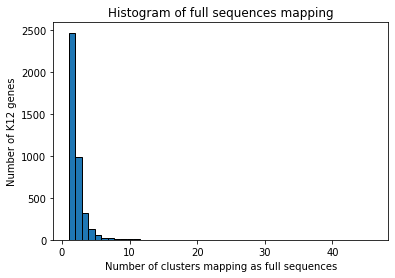

In [18]:
plt.hist(count_full_sequences,bins=np.max(np.array(count_full_sequences))+1,edgecolor='black')
plt.title("Histogram of full sequences mapping")
plt.xlabel("Number of clusters mapping as full sequences")
plt.ylabel("Number of K12 genes")
plt.show()

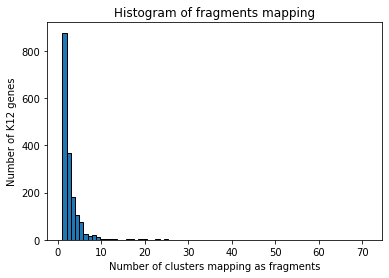

In [19]:
plt.hist(count_fragments,bins=np.max(np.array(count_fragments))+1,edgecolor='black')
plt.title("Histogram of fragments mapping")
plt.xlabel("Number of clusters mapping as fragments")
plt.ylabel("Number of K12 genes")
plt.show()

## Additionnal stuffs

In [7]:
results_clusters = pickle.load(open(RESULTS_CLUSTERS, 'rb'))
results_singletons = pickle.load(open(RESULTS_SINGLETONS, 'rb'))

In [44]:
reverse_results_singletons = dict()
for key in results_singletons.keys():
    hits = results_singletons[key]
    for i in range(len(hits)):
        if(hits[i].is_similar() or hits[i].is_fragment()):
            if(not hits[i].cluster_name in reverse_results_singletons.keys()):
                reverse_results_singletons[hits[i].cluster_name] = []
            reverse_results_singletons[hits[i].cluster_name].append(hits[i])

reverse_results_clusters = dict()
for key in results_clusters.keys():
    hits = results_clusters[key]
    for i in range(len(hits)):
        if(hits[i].is_similar() or hits[i].is_fragment()):
            if(not hits[i].cluster_name in reverse_results_clusters.keys()):
                reverse_results_clusters[hits[i].cluster_name] = []
            reverse_results_clusters[hits[i].cluster_name].append(hits[i])

In [32]:
gene_id = []
cluster_id = []
gene_length = []
fragment = []
singleton = []
bad_algnt = []
gaps = []
dashes = []

for key in reverse_results_singletons.keys():
    hits = reverse_results_singletons[key]
    if(len(hits)==1):
        gene_id.append(hits[0].gene_name.split("gene_")[1])
        cluster_id.append(hits[0].cluster_name[7:])
        gene_length.append(hits[0].get_gene_length())
        fragment.append(hits[0].is_fragment())
        singleton.append("True")
        bad_algnt.append("")
        gaps.append("")
        dashes.append("")

for key in reverse_results_clusters.keys():
    hits = reverse_results_clusters[key]
    if(len(hits)==1):
        gene_id.append(hits[0].gene_name.split("gene_")[1])
        cluster_id.append(hits[0].cluster_name[7:])
        gene_length.append(str(hits[0].get_gene_length()))
        fragment.append(str(hits[0].is_fragment()))
        singleton.append("False")
        sequence = [int(i=="-") for i in str(CLUSTERS_GAPS_FASTA[hits[0].cluster_name].seq)]
        a = sequence+[0]
        b = [0]+sequence
        c = [int((a[i]-b[i])==1) for i in range(len(a))]
        gaps_count = np.sum(np.array(c))
        dashes_count = np.sum(np.array(sequence))
        if(gaps_count>max(MAX_GAPS_PROP*len(sequence),MAX_GAPS_ABS) and dashes_count>0.1*len(sequence)):
            bad_algnt.append("True")
            gaps.append(str(gaps_count))
            dashes.append(str(dashes_count))
        else:
            bad_algnt.append("False")
            gaps.append("")
            dashes.append("")
        
df = pd.DataFrame({
    "gene_id":gene_id,
    "cluster_id":cluster_id,
    "gene_length":gene_length,
    "fragment":fragment,
    "singleton":singleton,
    "bad_algnt":bad_algnt,
    "gaps":gaps,
    "dashes":dashes
})
     
df.to_csv("gene_unique_clusters.csv",index=False)